<a href="https://colab.research.google.com/github/shitote/dist-repo/blob/main/Hate_speech_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.8 MB/s eta 0:00:00


In [ ]:
!pip install textblob

In [ ]:
!pip install wordcloud

In [ ]:
# Get the latest version of sklearn
!pip install --upgrade scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 82.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


In [ ]:
# chack the sklearm version
import sklearn
sklearn.__version__

'1.5.2'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib
import tensorflow as tf
from collections import Counter
from textblob import Word
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, f1_score, recall_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Activation, Dense, Embedding, LSTM, SpatialDropout1D, Dropout, Flatten, GRU, Conv1D, MaxPooling1D, Bidirectional
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image

## Load in the data.

In [ ]:
# read in the facebook data
facebook_hate = pd.read_csv("/content/drive/MyDrive/swahildataset/fb/hate/hate/fabook_data.csv")
facebook_more = pd.read_csv("/content/drive/MyDrive/swahildataset/fb/hate/hate/more_not.csv")
facebook_non_hate = pd.read_csv("/content/drive/MyDrive/swahildataset/fb/hate/hate/facebook_not_hate")
len(facebook_hate), len(facebook_non_hate)

(23650, 11079)

In [ ]:
# combine the facebook datasets
facebook_df = pd.concat([facebook_non_hate,facebook_more, facebook_hate], axis=0)
facebook_df.head()

,text,label
0,vipaji vinatengenezwarais wa jamhuri ya muunga...,3
1,picha ya siku,0
2,lazima iphone itajwe,0
3,man u wakimuona mzize wanapita naye,0
4,endelea kuchapa kazi kilimo kinalipa,0


In [ ]:
len(facebook_df)

36125

In [ ]:
# Read in the twitter data
twitter_data = pd.read_csv("/content/drive/MyDrive/swahili/data/data/raw_data/compine.csv")
len(twitter_data)

78297

In [ ]:
# Concatinate datasets
swahili_df = pd.concat([facebook_df, twitter_data], axis=0)
swahili_df.head(), len(swahili_df)

(                                                text label
 0  vipaji vinatengenezwarais wa jamhuri ya muunga...     3
 1                                      picha ya siku     0
 2                               lazima iphone itajwe     0
 3                man u wakimuona mzize wanapita naye     0
 4              endelea kuchapa kazi  kilimo kinalipa     0,
 114422)

In [ ]:
len(swahili_df)

114422

In [ ]:
swahili_df["label"].value_counts()

,count
label,
0,61850
1,17839
1,7615
2,3961
2,3639
0,3558
6,2729
4,2288
3,2277


In [ ]:
# remove the rows that contains strings
mask = swahili_df["label"].isin(["Kazi", "Mtoto", "Usiku", "Siku",
                               "Nyota", "Mwezi", "Jua", "Kitabu", "Shule",
                               "Rafiki", "Upendo", "Nyumba", "Chakula", "Maji",
                               "Tafadhali", "Kwaheri", "Habari", "Swahili", "label",
                                "Asante", "Ndiyo", "Hapana"])
swahili_df = swahili_df[~mask]

In [ ]:
swahili_df['label'].value_counts()

,count
label,
0,61850
1,17839
1,7615
2,3961
2,3639
0,3558
6,2729
4,2288
3,2277


In [ ]:
print(swahili_df['label'].dtype)

swahili_df['label'] = pd.to_numeric(swahili_df['label'], errors='coerce').fillna(0).astype(int)
swahili_df.drop_duplicates(inplace=True)
swahili_df = swahili_df.reset_index(drop=True)
print(swahili_df.columns)

object
Index(['text', 'label'], dtype='object')


<ipython-input-16-35b004c9fcdf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swahili_df['label'] = pd.to_numeric(swahili_df['label'], errors='coerce').fillna(0).astype(int)


In [ ]:
label_mapping = {
    0: 'not_hate',
    1: 'offensive',
    2: 'sexual',
    3: 'gender',
    4: 'disability',
    5: 'race',
    6: 'cronical_disease',
    7: 'religion',
    8: 'tribe',
}
swahili_df['label'] = swahili_df['label'].replace(label_mapping)
swahili_df.head()

,text,label
0,vipaji vinatengenezwarais wa jamhuri ya muunga...,gender
1,picha ya siku,not_hate
2,lazima iphone itajwe,not_hate
3,man u wakimuona mzize wanapita naye,not_hate
4,endelea kuchapa kazi kilimo kinalipa,not_hate


## Data Cleaning and Preprocessing

## Lowacasing all the letters

In [ ]:
swahili_df['text'] = swahili_df['text'].str.lower()
swahili_df.head()

,text,label
0,vipaji vinatengenezwarais wa jamhuri ya muunga...,gender
1,picha ya siku,not_hate
2,lazima iphone itajwe,not_hate
3,man u wakimuona mzize wanapita naye,not_hate
4,endelea kuchapa kazi kilimo kinalipa,not_hate


## Remove hastags and mentions

In [ ]:
import re

In [ ]:
swahili_df['text'] =swahili_df['text'].apply(str)
swahili_df.head()

,text,label
0,vipaji vinatengenezwarais wa jamhuri ya muunga...,gender
1,picha ya siku,not_hate
2,lazima iphone itajwe,not_hate
3,man u wakimuona mzize wanapita naye,not_hate
4,endelea kuchapa kazi kilimo kinalipa,not_hate


In [ ]:
# Remove all mentions.
swahili_df['text'] = swahili_df.apply(lambda row: re.sub("@[A-Za-z0-9_]+","", row['text']),axis=1)
swahili_df.head()

,text,label
0,vipaji vinatengenezwarais wa jamhuri ya muunga...,gender
1,picha ya siku,not_hate
2,lazima iphone itajwe,not_hate
3,man u wakimuona mzize wanapita naye,not_hate
4,endelea kuchapa kazi kilimo kinalipa,not_hate


In [ ]:
# Remove all hashtags
swahili_df['text'] = swahili_df.apply(lambda row: re.sub("#[A-Za-z0-9_]+","", row['text']),axis=1)
swahili_df.head()

,text,label
0,vipaji vinatengenezwarais wa jamhuri ya muunga...,gender
1,picha ya siku,not_hate
2,lazima iphone itajwe,not_hate
3,man u wakimuona mzize wanapita naye,not_hate
4,endelea kuchapa kazi kilimo kinalipa,not_hate


## Removing links

In [ ]:
# Remove https links
swahili_df['text'] = swahili_df.apply(lambda row: re.sub(r"http\S+","", row['text']),axis=1)
swahili_df.head()

,text,label
0,vipaji vinatengenezwarais wa jamhuri ya muunga...,gender
1,picha ya siku,not_hate
2,lazima iphone itajwe,not_hate
3,man u wakimuona mzize wanapita naye,not_hate
4,endelea kuchapa kazi kilimo kinalipa,not_hate


In [ ]:
# Remove www. links
swahili_df['text'] = swahili_df.apply(lambda row: re.sub(r"www. \S+","", row['text']),axis=1)
swahili_df.head()

,text,label
0,vipaji vinatengenezwarais wa jamhuri ya muunga...,gender
1,picha ya siku,not_hate
2,lazima iphone itajwe,not_hate
3,man u wakimuona mzize wanapita naye,not_hate
4,endelea kuchapa kazi kilimo kinalipa,not_hate


## Removing the punctuations

In [ ]:
swahili_df['text'] = swahili_df.apply(lambda row: re.sub('[()!?]'," ", row['text']),axis=1)
swahili_df.head()

,text,label
0,vipaji vinatengenezwarais wa jamhuri ya muunga...,gender
1,picha ya siku,not_hate
2,lazima iphone itajwe,not_hate
3,man u wakimuona mzize wanapita naye,not_hate
4,endelea kuchapa kazi kilimo kinalipa,not_hate


In [ ]:
swahili_df['text'] = swahili_df.apply(lambda row: re.sub('\[.*?\]'," ", row['text']),axis=1)
swahili_df.head()

,text,label
0,vipaji vinatengenezwarais wa jamhuri ya muunga...,gender
1,picha ya siku,not_hate
2,lazima iphone itajwe,not_hate
3,man u wakimuona mzize wanapita naye,not_hate
4,endelea kuchapa kazi kilimo kinalipa,not_hate


In [ ]:
## Removing all non-alphanumeric characters
swahili_df['text'] = swahili_df.apply(lambda row: re.sub("[^a-zA-Z0-9]"," ", row['text']),axis=1)
swahili_df.head()

,text,label
0,vipaji vinatengenezwarais wa jamhuri ya muunga...,gender
1,picha ya siku,not_hate
2,lazima iphone itajwe,not_hate
3,man u wakimuona mzize wanapita naye,not_hate
4,endelea kuchapa kazi kilimo kinalipa,not_hate


In [ ]:
# remove blank text rows
print("Total length before cleaning:", len(swahili_df))

blank_rows = swahili_df['text'].str.strip().eq('').fillna(True)
swahili_df = swahili_df[~blank_rows]

print("Total length after cleaning:", len(swahili_df))

Total length before cleaning: 113019
Total length after cleaning: 112734


## Checke and removeing all the duplicate values form the dataset

In [ ]:
 # check for the total af duplicate values.
swahili_df['text'].duplicated().sum()

851

In [ ]:
# Remove duplicate values on the text column
swahili_df.drop_duplicates(subset=['text'], inplace=True)
swahili_df.head()

,text,label
0,vipaji vinatengenezwarais wa jamhuri ya muunga...,gender
1,picha ya siku,not_hate
2,lazima iphone itajwe,not_hate
3,man u wakimuona mzize wanapita naye,not_hate
4,endelea kuchapa kazi kilimo kinalipa,not_hate


In [ ]:
swahili_df['text'].duplicated().sum()

0

In [ ]:
len(swahili_df)

111883

In [ ]:
# remove nan values for text col
swahili_df = swahili_df.dropna(subset=['text'])
len(swahili_df)

111883

In [ ]:
# Save the data
swahili_df.to_csv("/content/drive/MyDrive/swahili/data/data/final_datasets/cleaned_annotate_swahili_df.csv", index=False)

## Removing numerical values

In [ ]:
def cleaning_number(data):
  return re.sub('[0-9]+', '', data)

swahili_df['text']= swahili_df['text'].apply(lambda x: cleaning_number(x))
swahili_df.head()

,text,label
0,vipaji vinatengenezwarais wa jamhuri ya muunga...,gender
1,picha ya siku,not_hate
2,lazima iphone itajwe,not_hate
3,man u wakimuona mzize wanapita naye,not_hate
4,endelea kuchapa kazi kilimo kinalipa,not_hate


#### Replace the english words with their correspondng swahili words

In [ ]:
translation_df = pd.read_csv("/content/drive/MyDrive/swahili/data/data/final_datasets/swahiliEng.csv")
translation_df.tail()

,swahili,english
1461,hizi,these
1462,sahihi,signature
1463,miungano,movements
1464,hii,the
1465,finansi,finance


In [ ]:
# convert the dataframe to a dictionary
translation_dict = pd.Series(translation_df['swahili'].values,index=translation_df['english']).to_dict()
translation_dict

{'world': 'ulimwengu',
 'land': 'tua',
 'soil': 'udongo',
 'dust': 'vumbi',
 'mud': 'matope',
 'sand': 'mchanga',
 'hill': 'mlima',
 'mountain': 'kilima',
 'cliff': 'mwamba',
 'plain': 'tambarare',
 'valley': 'bonde',
 'island': 'kisiwa',
 'mainland': 'bara',
 'shore': 'pwani',
 'cave': 'pango',
 'water': 'maji',
 'sea': 'bahari',
 'calm': 'shwari',
 'rough': 'kwaruza',
 'foam': 'povu',
 'ocean': 'bahari',
 'lake': 'ziwa',
 'bay': 'ghuba',
 'reef': 'mwamba',
 'lagoon': 'wangwa',
 'cape': 'rasi',
 'wave': 'wimbi',
 'tide': 'kupwa',
 'low tide': 'maji kupwa',
 'high tide': 'maji kujaa',
 'river': 'mto',
 'spring': 'majira ya kuchipua',
 'well': 'kisima',
 'swamp': 'kinamasi',
 'waterfall': 'maporomoko ya maji',
 'forest': 'msitu',
 'woods': 'mwitu',
 'Savanna': 'mbuga',
 'desert': 'nyika',
 'tree': 'mti',
 'stone': 'jiwe',
 'earthquake': 'tetemeko la ardhi',
 'sky': 'anga',
 'sun': 'jua',
 'moon': 'mwezi',
 'star': 'nyota',
 'lightening': 'radi',
 'thunder': 'ngurumo',
 'storm': 'kimbung

In [ ]:
## Function to replace words using the dictionary
def translate_sentence(sentence, translation_dict):
  words = sentence.split()
  translated_words = [translation_dict.get(word, word) for word in words]
  return ' '.join(translated_words)

# apply the fuction to swahili df
swahili_df['text'] = swahili_df['text'].apply(lambda x: translate_sentence(x, translation_dict))
swahili_df

,text,label
0,vipaji vinatengenezwarais wa jamhuri ya muunga...,gender
1,picha ya siku,not_hate
2,lazima iphone itajwe,not_hate
3,mwanaume u wakimuona mzize wanapita naye,not_hate
4,endelea kuchapa kazi kilimo kinalipa,not_hate
...,...,...
113014,sisi ni wasomi taifa linatutegemea na tuna juk...,not_hate
113015,usikose kusikiliza kipindi cha jilawi kupitia ...,cronical_disease
113016,wizara ya elimu sayansi na teknolojia yaendele...,not_hate
113017,kila la kheri,not_hate


In [ ]:
# Save the data
swahili_df.to_csv("/content/drive/MyDrive/swahili/data/data/final_datasets/cleaned_swahili_df.csv", index=False)

In [ ]:
# Load in the Cleaned dataset
cleaned_df = pd.read_csv("/content/drive/MyDrive/swahili/data/data/final_datasets/cleaned_swahili_df.csv")
cleaned_df.head(), len(cleaned_df)

(                                                text     label
 0  vipaji vinatengenezwarais wa jamhuri ya muunga...    gender
 1                                      picha ya siku  not_hate
 2                               lazima iphone itajwe  not_hate
 3           mwanaume u wakimuona mzize wanapita naye  not_hate
 4               endelea kuchapa kazi kilimo kinalipa  not_hate,
 111883)

## EDA

### Define and remove all the stop words in Kiswahili and English

In [ ]:
cleaned_df.head()

,text,label
0,vipaji vinatengenezwarais wa jamhuri ya muunga...,gender
1,picha ya siku,not_hate
2,lazima iphone itajwe,not_hate
3,mwanaume u wakimuona mzize wanapita naye,not_hate
4,endelea kuchapa kazi kilimo kinalipa,not_hate


In [ ]:
# Check for duplicate based on text column
duplicate_rows = cleaned_df.duplicated(subset=['text'])

# Count the number of duplicates
num_duplicates = duplicate_rows.sum()

print("Number of duplicate rows:", num_duplicates)
print(len(cleaned_df))
cleaned_df = cleaned_df.drop_duplicates(subset=['text'])
print(len(cleaned_df))

Number of duplicate rows: 3996
111883
107887


In [ ]:
eng_stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'wewe', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [ ]:
STOPWORDS = set(eng_stopwordlist)
def cleaning_stopwords(text, stopwords):
  return " ".join([word for word in str(text).split() if word not in stopwords])
cleaned_df['text'] = cleaned_df['text'].apply(lambda text: cleaning_stopwords(text, STOPWORDS))
cleaned_df.head()

,text,label
0,vipaji vinatengenezwarais wa jamhuri ya muunga...,gender
1,picha ya siku,not_hate
2,lazima iphone itajwe,not_hate
3,mwanaume u wakimuona mzize wanapita naye,not_hate
4,endelea kuchapa kazi kilimo kinalipa,not_hate


### Removing white white spaces.

In [ ]:
def remove_whitespace(text):
  return " ".join(text.split())
cleaned_df['text'] = cleaned_df['text'].apply(lambda text: remove_whitespace(text))
cleaned_df.head(10)

,text,label
0,vipaji vinatengenezwarais wa jamhuri ya muunga...,gender
1,picha ya siku,not_hate
2,lazima iphone itajwe,not_hate
3,mwanaume u wakimuona mzize wanapita naye,not_hate
4,endelea kuchapa kazi kilimo kinalipa,not_hate
5,kazi ipo,not_hate
6,quote picha uliowahi kupiga usiku kwenye simu ...,not_hate
7,chelsea kuweni serious au mnataka mjitoe kwa m...,not_hate
8,kwa hiyo hautogombea tena,not_hate
9,akunti usipost muda mrefu followers lazima wap...,not_hate


In [ ]:
swahili_stopwords = pd.read_csv("/content/drive/MyDrive/swahili/data/data/final_datasets/swahili_stopwords.csv")
len(swahili_stopwords)

255

In [ ]:
swa_stopwords = swahili_stopwords['StopWords'].tolist()

In [ ]:
# Remove all swahili stopewords
STOPWORDS = set(swa_stopwords)
cleaned_df['text'] = cleaned_df['text'].apply(lambda text: cleaning_stopwords(text, STOPWORDS))
cleaned_df.head()

,text,label
0,vipaji vinatengenezwarais jamhuri muungano tan...,gender
1,picha siku,not_hate
2,lazima iphone itajwe,not_hate
3,mwanaume u wakimuona mzize wanapita naye,not_hate
4,endelea kuchapa kazi kilimo kinalipa,not_hate


In [ ]:
# save the dataset again
cleaned_df.to_csv("/content/drive/MyDrive/swahili/data/data/final_datasets/swahili_nostop_df.csv")

### Removing most used words.

In [ ]:
from collections import Counter
count = Counter()
for text in cleaned_df["text"].values:
    for word in text.split():
        count[word] += 1
count.most_common(20)

[('watu', 9717),
 ('ku', 9288),
 ('mtu', 9140),
 ('wako', 8586),
 ('huyu', 7153),
 ('kuna', 6802),
 ('leo', 6379),
 ('ndio', 6264),
 ('siku', 6231),
 ('mungu', 6096),
 ('kazi', 5127),
 ('mama', 4920),
 ('maisha', 4777),
 ('rais', 4542),
 ('mwanaume', 4513),
 ('kitu', 4285),
 ('mwanamke', 4254),
 ('mtoto', 4192),
 ('maana', 4135),
 ('wangu', 4011)]

In [ ]:
FREQWORDS = set([w for (w, wc) in count.most_common(10)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])
cleaned_df["text"] = cleaned_df["text"].apply(lambda text: remove_freqwords(text))
cleaned_df.head()

,text,label
0,vipaji vinatengenezwarais jamhuri muungano tan...,gender
1,picha,not_hate
2,lazima iphone itajwe,not_hate
3,mwanaume u wakimuona mzize wanapita naye,not_hate
4,endelea kuchapa kazi kilimo kinalipa,not_hate


### Plot a cloud of words for hate tweets

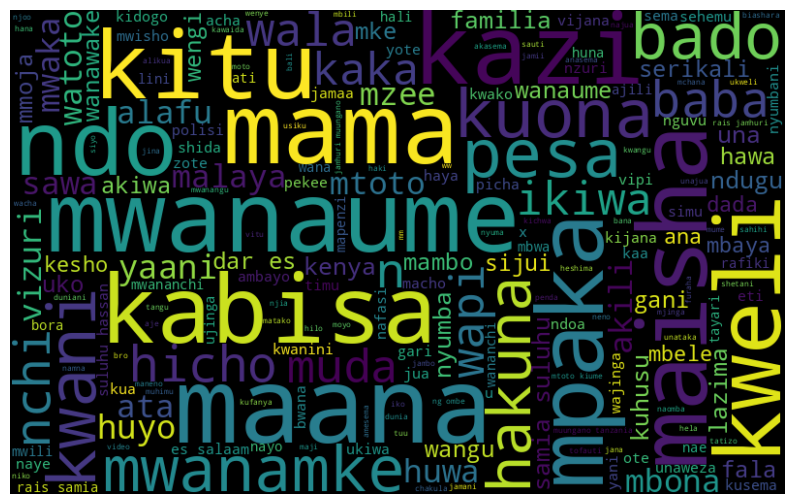

In [ ]:
%matplotlib inline
from wordcloud import WordCloud
normal_words =' '.join([text for text in cleaned_df['text']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


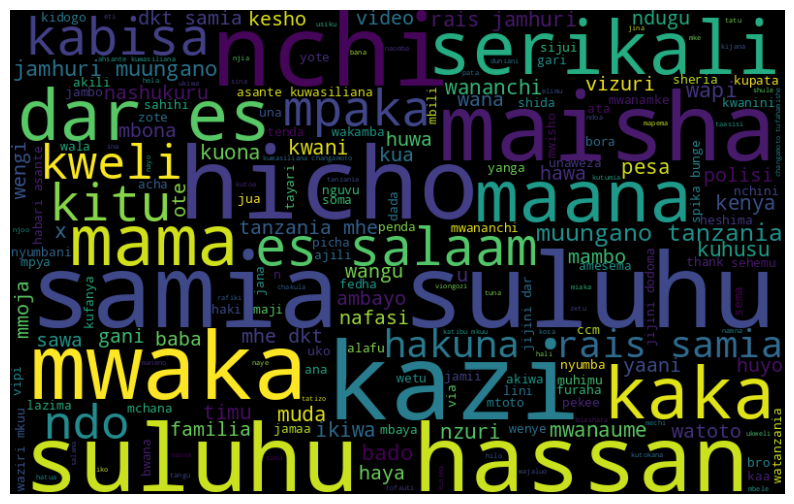

In [ ]:
# Check if there are any normal words
normal_words =' '.join([text for text in cleaned_df['text'][cleaned_df['label'] == 'not_hate']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

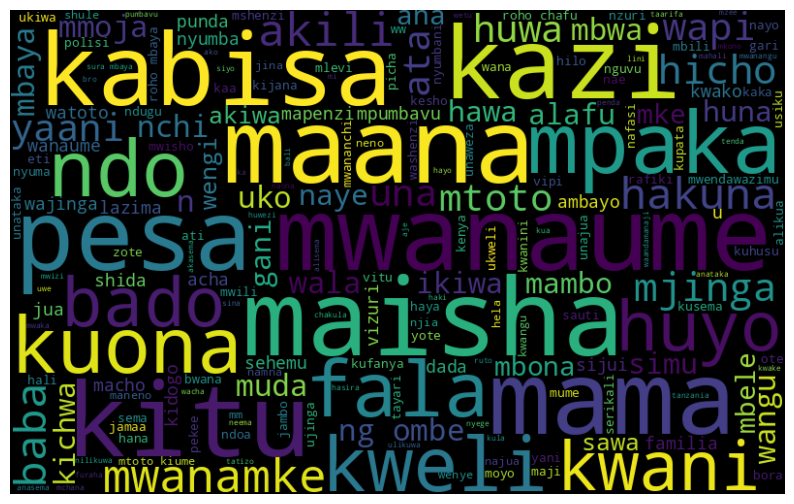

In [ ]:
normal_words =' '.join([text for text in cleaned_df['text'][cleaned_df['label'] == 'offensive']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

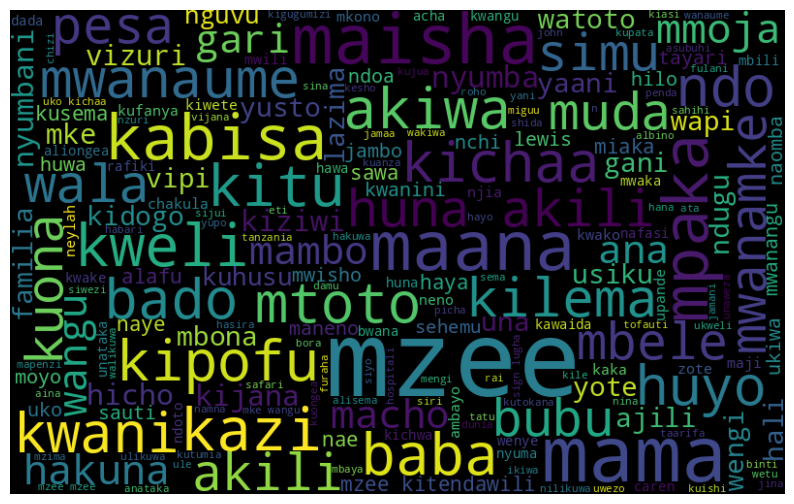

In [ ]:
normal_words =' '.join([text for text in cleaned_df['text'][cleaned_df['label'] == 'disability']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

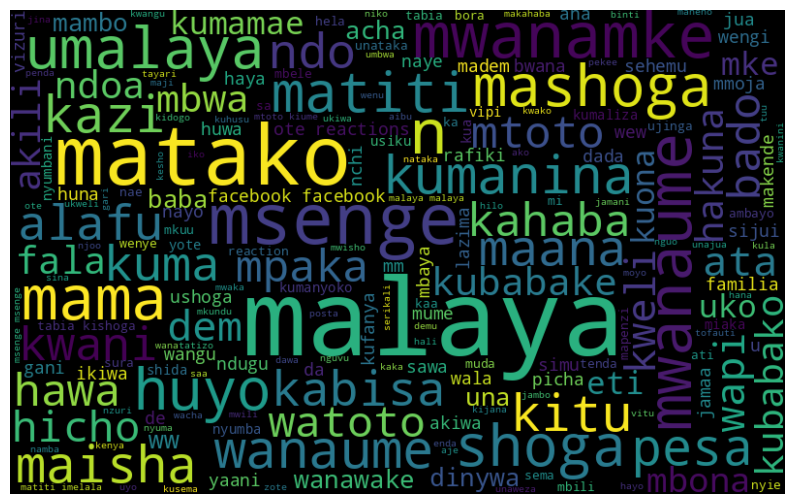

In [ ]:
normal_words =' '.join([text for text in cleaned_df['text'][cleaned_df['label'] == 'sexual']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

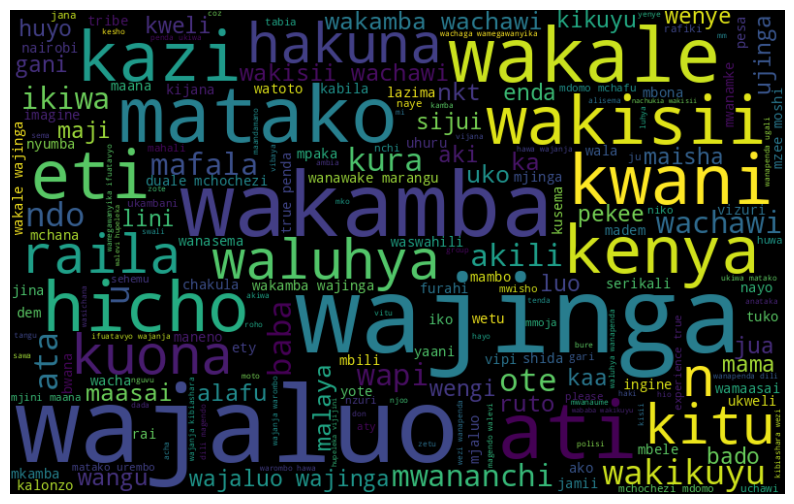

In [ ]:
normal_words =' '.join([text for text in cleaned_df['text'][cleaned_df['label'] == 'tribe']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

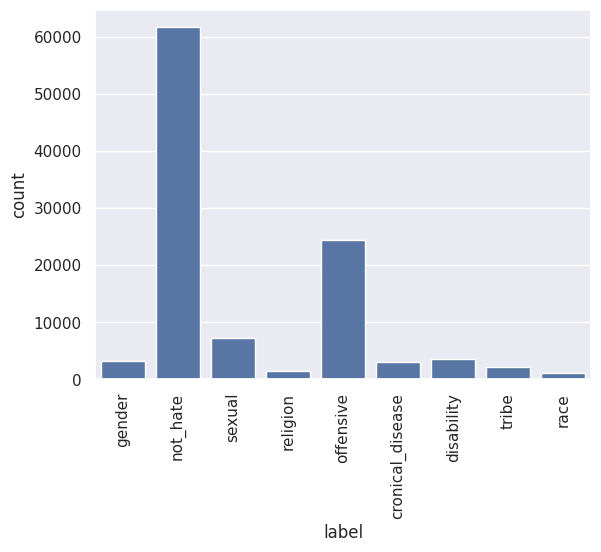

In [ ]:
sns.set_theme(style="darkgrid")
sns.countplot(x='label', data=cleaned_df)
# make the x labels labes align
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Check if the dataset is balanced
cleaned_df['label'].value_counts()

,count
label,
not_hate,61665
offensive,24349
sexual,7220
disability,3618
gender,3262
cronical_disease,3101
tribe,2203
religion,1430
race,1039


In [ ]:
# shuffle the dataset
cleaned_df_shuffled = cleaned_df.sample(frac=1).reset_index(drop=True)
cleaned_df_shuffled.head()

,text,label
0,mkuu kassim majaliwa ametoa wito wakunga wataa...,not_hate
1,amka fredwaa power kiamshakinywa clouds fm upa...,not_hate
2,tukikosana usiende kununua chips mahali niliku...,sexual
3,umeona eee wew mwizi wamekukataa kuangalia pro...,offensive
4,helloo bado madem wanapelekwa saudi nimengoja ...,not_hate


In [ ]:
#save the shuffled data
cleaned_df_shuffled.to_csv("/content/drive/MyDrive/swahili/data/data/final_datasets/shuffled_swahili_df.csv", index=False)

In [ ]:
# blalche the dataset by under sampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
# Visualize random traning examples.
import random
random_index = random.randint(0, len(cleaned_df_shuffled))
for row in cleaned_df_shuffled[['text', 'label']][random_index:random_index+5].itertuples():
  _, text, label = row
  # Check if the label is not 'non_hate' before printing '(hate_speech)'
  print(f'Labels: {label}', '(hate_speech)' if label != 'non_hate' else '(Note hate_speech)')
  print(f'Text:\n{text}\n')
  print("----------------------\n")

Labels: offensive (hate_speech)
Text:
nitumie jumapili kumtakia matashi mema mwadhama protase kardinali rugambwa consistory jana iliyofanywa mwenyezi aendelee kumwangazia mwanga huruma hekima haki endelee kichocheo utu haki amani

----------------------

Labels: offensive (hate_speech)
Text:
ubungo ambayo kimara yote haina maji mitaani tupo kandahar tatizo foleni korogwe kimara mwisho angepush tanroads wafanye jambo mbezi mwisho vurugu wamachinga soko nzi mwehu

----------------------

Labels: offensive (hate_speech)
Text:
ata wahenga walisema ujana moshi ww unanuka chapo chips shiet

----------------------

Labels: not_hate (hate_speech)
Text:
hatupost kua tunapenda posta but tuna posta tunataka kuongea thru ur comments tunaongea tunacheka maisha yanasonga tunaenda bar eti tunapenda tunaona mahali tunaeza poteza mawazo unaponipata nakukupea tabasamu eti nina furaha bali najaribu kuficha yale yaliyo moyoni kuona

----------------------

Labels: not_hate (hate_speech)
Text:
kheee aisee


### Split the dataset into training and validation datasets

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Slipt the dataset
train_sentences, valid_sentences, train_labels, valid_labels = train_test_split(
    cleaned_df_shuffled['text'].to_numpy(),
    cleaned_df_shuffled['label'].to_numpy(),
    test_size=0.1,
    random_state=42
)
len(train_sentences), len(valid_sentences)

(97098, 10789)

In [ ]:
len(train_sentences), len(train_labels)

(97098, 97098)

In [ ]:
train_sentences[:5], train_labels[:5]

(array(['ujinga watanazania amkeni ndugai hakua mjinga alisema ipo nchi utapigwa mnada nimeona bandari zetu zinatwaliwa dubai kwasababu kudaiwa anatokea mpumbavu mmoja anasema watabinafsisha bandari zetu miaka wanaakili hawa bandari zetu zuchukuliwe waarabu miaka mmelewa nyie mnaona miaka kam miezi sita yaani mnaibinafsisha nchi madeni wameiba mabilion shilingi hamuwachukulii hatua mnabaki mkisema mama anaupiga mwingi mnasifia ujinga dah ngoja ninyamaze maana sina pesa kumlipa wakili',
        'sjui nn waafrica wajinga xn kias hki km akichanja hazuii maambukz anaweza kuambukizwa nn mnamlazmisha',
        'nyoka kiwete shosho anajiita sonia dabbie ungekua mbwa mbwa ako afadhali kukuliko vitu unafanya toa filters unakaa jitu filters qwani huchoki kujipendekeza wanaume',
        'amekaa miaka kicheche', 'kubaba box kusafisha makalio elderly'],
       dtype=object),
 array(['not_hate', 'race', 'disability', 'sexual', 'not_hate'],
       dtype=object))

## Convert Text to Numbers.

* Tokenization - Direxct mapping of tokens to numbers
* Embedding - Mapping of words to vectors

### Text Vectorization(Tokenization)

In [ ]:
len(train_sentences[0][0]. split())

1

In [ ]:
# Find the average number of tokens in the training datasets.
round(sum([len(str(i).split()) for i in train_sentences])/len(train_sentences))

17

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# set text vexctorization variables
max_vocab_lenght = 20000
max_length = 20

text_vectorizer = TextVectorization(max_tokens=max_vocab_lenght,
                                    output_mode='int',
                                    output_sequence_length=max_length,
                                    )

In [ ]:
# Fit the vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [ ]:
# Tokenize a sample sentence
sample_sentence = "huna heshima kabisa"
text_vectorizer(sample_sentence)

<tf.Tensor: shape=(20,), dtype=int64, numpy=
array([ 52, 198,  13,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0])>

In [ ]:
# choose a random sentence from the training sentences
random_sentence = random.choice(train_sentences)
print(f'Original text: \n {random_sentence}\n\n Vectorized version:')
text_vectorizer([random_sentence])

Original text: 
 safi mgenge ngoma bado moto

 Vectorized version:


<tf.Tensor: shape=(1, 20), dtype=int64, numpy=
array([[386,   1, 838,  30, 278,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0]])>

In [ ]:
# Get unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:10]
bottom_5_words = words_in_vocab[-5:]
print(f'Number of words in vocab: {len(words_in_vocab)}')
print(f'10 most common words: {top_5_words}')
print(f'5 least common words: {bottom_5_words}')

Number of words in vocab: 20000
10 most common words: ['', '[UNK]', 'kazi', 'maisha', 'mama', 'rais', 'mwanaume', 'mwanamke', 'kitu', 'maana']
5 least common words: ['taraka', 'tanzlite', 'tamb', 'tam', 'tala']


### Create an Embedding

In [ ]:
from tensorflow.keras import layers
embedding = layers.Embedding(input_dim=max_vocab_lenght,
                             output_dim=128,
                             input_length=max_length)
embedding

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


<Embedding name=embedding_2, built=False>

In [ ]:
# visualize after embedding
print(f'Original text: \n {random_sentence} \
      \n\nEmbedded version: ')
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text: 
 safi mgenge ngoma bado moto       

Embedded version: 


<tf.Tensor: shape=(1, 20, 128), dtype=float32, numpy=
array([[[ 0.0058613 ,  0.00839673,  0.04685735, ..., -0.01612119,
         -0.00690583, -0.03104346],
        [ 0.02235216,  0.02359151, -0.00463684, ..., -0.01173471,
          0.04869567, -0.02803453],
        [ 0.04538547,  0.0087069 , -0.0073303 , ..., -0.02260588,
         -0.04611515, -0.04621159],
        ...,
        [ 0.0091051 , -0.02447137, -0.01237037, ..., -0.00711429,
          0.03218578,  0.02492471],
        [ 0.0091051 , -0.02447137, -0.01237037, ..., -0.00711429,
          0.03218578,  0.02492471],
        [ 0.0091051 , -0.02447137, -0.01237037, ..., -0.00711429,
          0.03218578,  0.02492471]]], dtype=float32)>

## Modeling
### Baseline model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [ ]:
# Create a data pipeline
model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Baseline model evaluation
baseline_score = model_0.score(valid_sentences, valid_labels)
print(f"baseline model score: {baseline_score*100:.2f}%")
baseline_preds = model_0.predict(valid_sentences)
print(classification_report(valid_labels, baseline_preds))

baseline model score: 67.93%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                  precision    recall  f1-score   support

cronical_disease       1.00      0.03      0.05       334
      disability       0.95      0.06      0.11       317
          gender       1.00      0.01      0.02       320
        not_hate       0.66      0.99      0.79      6125
       offensive       0.74      0.46      0.57      2503
            race       0.00      0.00      0.00        87
        religion       0.00      0.00      0.00       155
          sexual       0.91      0.14      0.25       739
           tribe       1.00      0.00      0.01       209

        accuracy                           0.68     10789
       macro avg       0.70      0.19      0.20     10789
    weighted avg       0.72      0.68      0.60     10789



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Model Evaluation based on: accuracy score, precision score, recall, f1_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculate model accuracy, precision, recall and f1 score of a binary classification model.
  """
  if isinstance(y_true[0], str):
    label_mapping = {'offensive': 1, 'not_hate': 0,
                     'sexual': 2,
                      'gender': 3,
                      'disability': 4,
                      'race': 5,
                      'cronical_disease': 6,
                      'religion': 7,
                      'tribe': 8,
                     }
    y_true = [label_mapping[label] for label in y_true]

  if isinstance(y_pred[0], str):
    label_mapping = {'offensive': 1, 'not_hate': 0,
                     'sexual': 2,
                      'gender': 3,
                      'disability': 4,
                      'race': 5,
                      'cronical_disease': 6,
                      'religion': 7,
                      'tribe': 8,
                     }
    y_pred = [label_mapping[label] for label in y_pred]

  model_accuracy = accuracy_score(y_true, y_pred) * 100
  y_pred_proba = model_0.predict_proba(valid_sentences)
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(
      y_true,
      y_pred,
      average="weighted")
  model_results = {
      "accuracy": model_accuracy,
      "precision": (model_precision)*100,
      "recall": (model_recall)*100,
      "f1": (model_f1)*100,
  }
  return model_results

In [ ]:
# claculate the model results
model_0_results = calculate_results(y_true=valid_labels,
                                    y_pred=baseline_preds)
model_0_results

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'accuracy': 67.93029937899713,
 'precision': 72.03187222720324,
 'recall': 67.93029937899713,
 'f1': 60.48633672406446}

In [ ]:
# f-1 score and ROC_AUC
from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(valid_labels, baseline_preds))

                  precision    recall  f1-score   support

cronical_disease       1.00      0.03      0.05       334
      disability       0.95      0.06      0.11       317
          gender       1.00      0.01      0.02       320
        not_hate       0.66      0.99      0.79      6125
       offensive       0.74      0.46      0.57      2503
            race       0.00      0.00      0.00        87
        religion       0.00      0.00      0.00       155
          sexual       0.91      0.14      0.25       739
           tribe       1.00      0.00      0.01       209

        accuracy                           0.68     10789
       macro avg       0.70      0.19      0.20     10789
    weighted avg       0.72      0.68      0.60     10789



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### SVM

**A support vector machine (SVM) is a machine learning algorithm that uses supervised learning models to solve complex classification, regression, and outlier detection problems by performing optimal data transformations that determine boundaries between data points based on predefined classes, labels, or outputs. SVMs are widely adopted across disciplines such as healthcare, natural language processing, signal processing applications, and speech & image recognition fields**

In [ ]:
%%time
from sklearn.svm import SVC, LinearSVC
model_1_svm = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC())
])

# fit the model
model_1_svm.fit(train_sentences, train_labels)

CPU times: user 6.38 s, sys: 19.8 ms, total: 6.4 s
Wall time: 6.45 s


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LinearSVC())])

In [ ]:
model_1_svm.score(valid_sentences, valid_labels)
print(classification_report(valid_labels, model_1_svm.predict(valid_sentences)))

                  precision    recall  f1-score   support

cronical_disease       0.89      0.71      0.79       334
      disability       0.91      0.76      0.83       317
          gender       0.89      0.68      0.77       320
        not_hate       0.90      0.96      0.93      6125
       offensive       0.85      0.82      0.83      2503
            race       0.75      0.56      0.64        87
        religion       0.92      0.86      0.89       155
          sexual       0.91      0.86      0.89       739
           tribe       0.81      0.65      0.72       209

        accuracy                           0.89     10789
       macro avg       0.87      0.76      0.81     10789
    weighted avg       0.89      0.89      0.89     10789



In [ ]:
# Calculate the models results
model_1_svm_results = calculate_results(y_true=valid_labels,
                                        y_pred=model_1_svm.predict(valid_sentences))
model_1_svm_results

{'accuracy': 88.81267958105478,
 'precision': 88.69282728504406,
 'recall': 88.81267958105478,
 'f1': 88.56446684416305}

In [ ]:
# Make Predictions
model_1_svm_preds = model_1_svm.predict(valid_sentences)
model_1_svm_preds[:20]

array(['not_hate', 'not_hate', 'not_hate', 'gender', 'tribe', 'not_hate',
       'not_hate', 'not_hate', 'disability', 'not_hate', 'not_hate',
       'offensive', 'not_hate', 'not_hate', 'not_hate', 'not_hate',
       'offensive', 'not_hate', 'not_hate', 'religion'], dtype=object)

In [ ]:
# Find the prediction probabilities
decision_score = model_1_svm.decision_function(valid_sentences)
decision_score[0]


array([-1.20892978, -1.11792202, -1.36487585,  1.61820225, -1.25288515,
       -1.42166292, -1.23395463, -1.27351109, -1.40187894])

In [ ]:
# save the model
import pickle
with open("/content/drive/MyDrive/swahili/models/model_1_svm.pkl", "wb") as file:
  pickle.dump(model_1_svm, file)

### ⏳Search for optimal parameters for SVM algotithm

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
model_1_pram = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l1',
                          alpha=0.0001, l1_ratio=0.15,
                          fit_intercept=True, max_iter=1000,
                          tol=0.001, shuffle=True, verbose=0,
                          epsilon=0.1, n_jobs=None, random_state=None,
                          learning_rate='optimal', eta0=0.0,
                          power_t=0.5, early_stopping=False,
                          validation_fraction=0.1, n_iter_no_change=5,
                          class_weight=None, warm_start=False, average=False))
])
model_1_pram.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', SGDClassifier(penalty='l1'))])

In [ ]:
model_1_pram.score(valid_sentences, valid_labels)

0.8532764853091112

In [ ]:
# save the model results
with open("/content/drive/MyDrive/swahili/models/model_1_pram.pkl", "wb") as file:
  pickle.dump(model_1_pram, file)

### Logistic regresion
**Logistic Regression is a “Supervised machine learning” algorithm that can be used to model the probability of a certain class or event. It is used when the data is linearly separable and the outcome is binary or dichotomous in nature.**


In [ ]:
from sklearn.linear_model import LogisticRegression
model_logisctic = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])

model_logisctic.fit(train_sentences, train_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LogisticRegression())])

In [ ]:
# find the model score
model_logisctic.score(valid_sentences, valid_labels)

0.8680137176754101

In [ ]:
# Calculate them models results
model_logisctic_results = calculate_results(y_true=valid_labels,
                                             y_pred=model_logisctic.predict(valid_sentences))
model_logisctic_results

{'accuracy': 86.80137176754101,
 'precision': 86.80652051166653,
 'recall': 86.80137176754101,
 'f1': 86.24704658456065}

In [ ]:
# make predictins
model_logisctic_preds = model_logisctic.predict(valid_sentences)
model_logisctic_preds[:20]

array(['not_hate', 'not_hate', 'not_hate', 'gender', 'tribe', 'not_hate',
       'not_hate', 'not_hate', 'disability', 'not_hate', 'not_hate',
       'offensive', 'not_hate', 'not_hate', 'not_hate', 'not_hate',
       'offensive', 'not_hate', 'not_hate', 'not_hate'], dtype=object)

In [ ]:
# classification report
print(classification_report(valid_labels, model_logisctic_preds))

                  precision    recall  f1-score   support

cronical_disease       0.89      0.58      0.70       334
      disability       0.90      0.62      0.73       317
          gender       0.84      0.61      0.71       320
        not_hate       0.87      0.97      0.92      6125
       offensive       0.84      0.81      0.83      2503
            race       0.80      0.46      0.58        87
        religion       0.94      0.64      0.76       155
          sexual       0.90      0.75      0.82       739
           tribe       0.84      0.56      0.67       209

        accuracy                           0.87     10789
       macro avg       0.87      0.67      0.75     10789
    weighted avg       0.87      0.87      0.86     10789



In [ ]:
# Save
with open("/content/drive/MyDrive/swahili/models/model_logisctic.pkl", "wb") as file:
  pickle.dump(model_logisctic, file)

#### ⌛ Logistic regression hyperparameters

In [ ]:
from sklearn.model_selection import GridSearchCV
small_param_grid = [
    {
        'tfidf__ngram_range': [(1, 1)],
        'tfidf__stop_words': [None],
        'tfidf__tokenizer': [None],
        'tfidf__use_idf': [False],
        'tfidf__norm': [None],
        'clf__penalty': ['l1', 'l2'],
        'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    },
    {
        'tfidf__ngram_range': [(1, 1)],
        'tfidf__stop_words': [None],
        'tfidf__tokenizer': [None],
        'tfidf__use_idf': [False],
        'tfidf__norm': [None],
        'clf__penalty': ['l1', 'l2'],
        'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    }
]

lr_grid_search = GridSearchCV(model_logisctic, small_param_grid,
                              cv=5,
                              scoring='accuracy',
                              verbose=True)
lr_grid_search.fit(train_sentences, train_labels)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', LogisticRegression())]),
             param_grid=[{'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'clf__penalty': ['l1', 'l2'],
                          'tfidf__ngram_range': [(1, 1)], 'tfidf__norm': [None],
                          'tfidf__stop_words': [None],
                          'tfidf__tokenizer': [None],
                          'tfidf__use_idf': [False]},
                         {'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'clf__penalty': ['l1', 'l2'],
                          'tfidf__ngram_range': [(1, 1)], 'tfidf__norm': [None],
                          'tfidf__stop_words': [None],
                          'tfidf__tokenizer': [None],
                          'tfidf__use_idf': [False]}],
             scoring='accuracy', verbose=True)

In [ ]:
# score the model
lr_grid_search.score(valid_sentences, valid_labels)

0.8937807025674298

In [ ]:
# calculate model results
lr_grid_search_results = calculate_results(y_true=valid_labels,
                                            y_pred=lr_grid_search.predict(valid_sentences))
lr_grid_search_results


{'accuracy': 89.37807025674299,
 'precision': 89.18729840831051,
 'recall': 89.37807025674299,
 'f1': 89.13107585634715}

In [ ]:
# make predictions
lr_grid_search_preds = lr_grid_search.predict(valid_sentences)
lr_grid_search_preds[:10]

array(['not_hate', 'not_hate', 'not_hate', 'not_hate', 'not_hate',
       'not_hate', 'not_hate', 'not_hate', 'disability', 'not_hate'],
      dtype=object)

In [ ]:
# Find the best params
lr_grid_search.best_params_

{'clf__C': 1,
 'clf__penalty': 'l2',
 'tfidf__ngram_range': (1, 1),
 'tfidf__norm': None,
 'tfidf__stop_words': None,
 'tfidf__tokenizer': None,
 'tfidf__use_idf': False}

In [ ]:
# save the model.
with open("/content/drive/MyDrive/swahili/models/model_logisctic_grid_search.pkl", "wb") as file:
  pickle.dump(lr_grid_search, file)


In [ ]:
# load in the model
with open("/content/drive/MyDrive/swahili/models/model_logisctic_grid_search.pkl", "rb") as file:
  lr_grid_search = pickle.load(file)

In [ ]:
# calculate the model result
lr_grid_search_results = calculate_results(y_true=valid_labels,
                                            y_pred=lr_grid_search.predict(valid_sentences))
lr_grid_search_results

{'accuracy': 89.37807025674299,
 'precision': 89.18729840831051,
 'recall': 89.37807025674299,
 'f1': 89.13107585634715}

In [ ]:
# find the prediction probabilities for the model
prediction_probs = lr_grid_search.predict_proba(valid_sentences)
prediction_probs[:10]

array([[1.19223333e-03, 4.45319032e-03, 1.82094616e-03, 9.86026036e-01,
        4.33551898e-03, 4.84281911e-04, 2.61809690e-04, 1.10627658e-03,
        3.19707052e-04],
       [1.01278845e-03, 2.96964202e-03, 4.29537039e-03, 9.31915563e-01,
        5.11216312e-02, 1.04035645e-03, 6.24613824e-04, 5.54324078e-03,
        1.47679400e-03],
       [2.70865366e-03, 2.76271694e-03, 1.31771327e-03, 9.09840418e-01,
        6.94055610e-02, 1.77357412e-03, 2.29829587e-03, 7.83525280e-03,
        2.05781473e-03],
       [9.84900566e-03, 5.81623795e-03, 1.18525040e-01, 8.28132856e-01,
        2.42533340e-02, 6.01455961e-04, 7.55058415e-04, 6.39539359e-03,
        5.67161810e-03],
       [1.15541330e-03, 1.94371431e-03, 9.73587235e-04, 5.03433359e-01,
        1.53864691e-03, 3.36969919e-04, 8.06982249e-04, 1.69382481e-02,
        4.72873079e-01],
       [4.04429398e-04, 1.53929135e-03, 2.83653003e-04, 9.89393599e-01,
        7.09989336e-03, 5.48100733e-04, 6.80656950e-05, 5.28862318e-04,
        1.3

### DecisionTreeClassifier

In [ ]:
%%time
from sklearn.tree import DecisionTreeClassifier

model_dt = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', DecisionTreeClassifier())
])
model_dt.fit(train_sentences, train_labels)

CPU times: user 5min 10s, sys: 396 ms, total: 5min 10s
Wall time: 5min 18s


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', DecisionTreeClassifier())])

In [ ]:
# score the model
model_dt.score(valid_sentences, valid_labels)

0.8816387060895357

In [ ]:
# make predictions
model_dt_preds = model_dt.predict(valid_sentences)
model_dt_preds[:10]

array(['not_hate', 'not_hate', 'not_hate', 'gender', 'tribe', 'not_hate',
       'not_hate', 'not_hate', 'disability', 'not_hate'], dtype=object)

In [ ]:
valid_labels[:10]

array(['not_hate', 'not_hate', 'not_hate', 'gender', 'tribe', 'not_hate',
       'cronical_disease', 'not_hate', 'disability', 'not_hate'],
      dtype=object)

In [ ]:
# calculate the model results
model_dt_results = calculate_results(y_true=valid_labels,
                                      y_pred=model_dt_preds)
model_dt_results

{'accuracy': 88.16387060895356,
 'precision': 88.0292723976373,
 'recall': 88.16387060895356,
 'f1': 88.0430141421881}

In [ ]:
# create a text vectrizer for the training and validation sentences
x_train_tfv = text_vectorizer(train_sentences)
x_valid_tfv = text_vectorizer(valid_sentences)

In [ ]:
# comapre the cost-complexity prunning path
%%time
tree_model = model_dt.named_steps['clf']
path = tree_model.cost_complexity_pruning_path(x_train_tfv, train_labels)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

print(ccp_alphas)
print(impurities)

[0.         0.         0.         ... 0.0015242  0.00281946 0.0132475 ]
[0.00614632 0.00614632 0.00614632 ... 0.59809823 0.60091769 0.61416519]
CPU times: user 6.04 s, sys: 5.77 ms, total: 6.05 s
Wall time: 6.03 s


Text(0.5, 1.0, 'Total Impurity vs Effective alpha for training set')

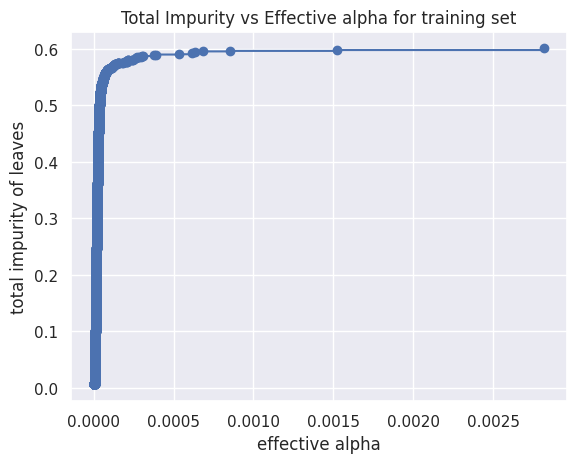

In [ ]:
# plot the pruning path
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle='steps-post')
ax.set_xlabel('effective alpha')
ax.set_ylabel('total impurity of leaves')
ax.set_title('Total Impurity vs Effective alpha for training set')

In [ ]:
# save the model
with open("/content/drive/MyDrive/swahili/models/model_dt.pkl", "wb") as file:
  pickle.dump(model_dt, file)

### RandomForestClassifier

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier
model_rf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier())
])
model_rf.fit(train_sentences, train_labels)

CPU times: user 19min 52s, sys: 2.02 s, total: 19min 54s
Wall time: 20min 2s


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', RandomForestClassifier())])

In [ ]:
# Random forest model score
model_rf_score = model_rf.score(valid_sentences, valid_labels)
print(f"Random forest model score: {model_rf_score*100:.2f}%")

Random forest model score: 88.12%


In [ ]:
model_rf_score = model_rf.score(train_sentences, train_labels)
print(f"Random forest model score: {model_rf_score*100:.2f}%")

Random forest model score: 99.85%


In [ ]:
# calculate model results
model_rf_results = calculate_results(y_true=valid_labels,
                                      y_pred=model_rf.predict(valid_sentences))
model_rf_results

{'accuracy': 88.11752711094634,
 'precision': 88.37885801859105,
 'recall': 88.11752711094634,
 'f1': 87.54111196435807}

In [ ]:
# Make predictions
model_rf_preds = model_rf.predict(valid_sentences)
model_rf_preds[:10]

array(['not_hate', 'not_hate', 'not_hate', 'gender', 'tribe', 'not_hate',
       'offensive', 'not_hate', 'disability', 'not_hate'], dtype=object)

In [ ]:
# Classification report
print(classification_report(valid_labels, model_rf_preds))

                  precision    recall  f1-score   support

cronical_disease       0.94      0.63      0.75       334
      disability       0.93      0.68      0.78       317
          gender       0.93      0.58      0.71       320
        not_hate       0.89      0.98      0.93      6125
       offensive       0.84      0.84      0.84      2503
            race       0.85      0.38      0.52        87
        religion       0.93      0.71      0.81       155
          sexual       0.93      0.78      0.85       739
           tribe       0.97      0.47      0.63       209

        accuracy                           0.88     10789
       macro avg       0.91      0.67      0.76     10789
    weighted avg       0.88      0.88      0.88     10789



In [ ]:
# save the model
with open("/content/drive/MyDrive/swahili/models/model_rf.pkl", "wb") as file:
  pickle.dump(model_rf, file)

In [ ]:
model_rf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs= -1,                               random_state=42))
])
model_rf.fit(train_sentences, train_labels)
model_rf_score = model_rf.score(valid_sentences, valid_labels)
print(f"Random forest model score: {model_rf_score*100:.2f}%")

Random forest model score: 87.70%


## Deep Modeling

### Recurrent Nural Network(RNN)
#### Model 1: LSTM 1-layer

A long short-term memory network is a type of recurrent neural network (RNN).

* LSTMs are predominantly used to learn, process, and classify sequential data.
* They are user because these networks can learn long-term dependencies between time steps of data.

In [ ]:
from tensorflow.keras import layers
import tensorflow as tf

# Sequential model
model_lstm1 = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),  # Input layer
    text_vectorizer,                            # Text vectorization layer
    embedding,                                  # Embedding layer
    SpatialDropout1D(0.8),
    Bidirectional(LSTM(300, dropout=0.5, recurrent_dropout=0.5)),
    Dropout(0.5),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(9, activation='softmax'),
])

# Name the model
model_lstm1._name = 'Model_1_dense_sequential'

In [ ]:
# Show the model summary.
model_lstm1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization_1                 │ (None, 20)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 20, 128)             │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_2                  │ (None, 20, 128)             │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 600)                 │       1,029,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 600)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 600)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │          38,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,628,649 (13.84 MB)

 Trainable params: 3,628,649 (13.84 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# compile the model
model_lstm1.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
valid_label_series = pd.Series(valid_labels)
valid_label_series.value_counts()

,count
not_hate,6145
offensive,2445
sexual,725
disability,375
gender,331
cronical_disease,308
tribe,205
religion,144
race,111


In [ ]:

# model check points
checkpoint_callback = ModelCheckpoint(filepath="lastm-1-layer-best_model.keras", save_best_only=True, monitor="val_acc", mode="max", verbose=1)
early_stopping_callback = EarlyStopping(monitor="val_acc", mode="max", patience=10, verbose=1, restore_best_weights=True)

reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]


In [ ]:
# convert string labels to numerical values
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
valid_labels = label_encoder.fit_transform(valid_labels)

# is your original labels array
train_labels = tf.keras.utils.to_categorical(train_labels)
valid_labels = tf.keras.utils.to_categorical(valid_labels)

In [ ]:
# fit the model
history_model_lstm1 = model_lstm1.fit(train_sentences,
                              train_labels,
                              epochs=10,
                              batch_size=32,
                              validation_data=(valid_sentences, valid_labels),
                              callbacks=callbacks)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:567: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


3035/3035 ━━━━━━━━━━━━━━━━━━━━ 269s 85ms/step - accuracy: 0.6152 - loss: 1.2226 - val_accuracy: 0.7977 - val_loss: 0.7023 - learning_rate: 0.0010
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


3035/3035 ━━━━━━━━━━━━━━━━━━━━ 298s 79ms/step - accuracy: 0.7817 - loss: 0.7771 - val_accuracy: 0.8463 - val_loss: 0.5583 - learning_rate: 0.0010
Epoch 3/10
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 264s 79ms/step - accuracy: 0.8171 - loss: 0.6756 - val_accuracy: 0.8512 - val_loss: 0.5572 - learning_rate: 0.0010
Epoch 4/10
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 260s 79ms/step - accuracy: 0.8343 - loss: 0.6150 - val_accuracy: 0.8707 - val_loss: 0.4966 - learning_rate: 0.0010
Epoch 5/10
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 263s 79ms/step - accuracy: 0.8489 - loss: 0.5720 - val_accuracy: 0.8718 - val_loss: 0.5012 - learning_rate: 0.0010
Epoch 6/10
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 264s 80ms/step - accuracy: 0.8560 - loss: 0.5435 - val_accuracy: 0.8752 - val_loss: 0.4729 - learning_rate: 0.0010
Epoch 7/10
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 240s 79ms/step - accuracy: 0.8606 - loss: 0.5265 - val_accuracy: 0.8777 - val_loss: 0.4675 - learning_rate: 0.0010
Epoch 8/10
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 261s 79ms/step - accuracy: 

In [ ]:
# save the model
with open("/content/drive/MyDrive/swahili/models/model_lstm1.pkl", "wb") as file:
  pickle.dump(model_lstm1, file)

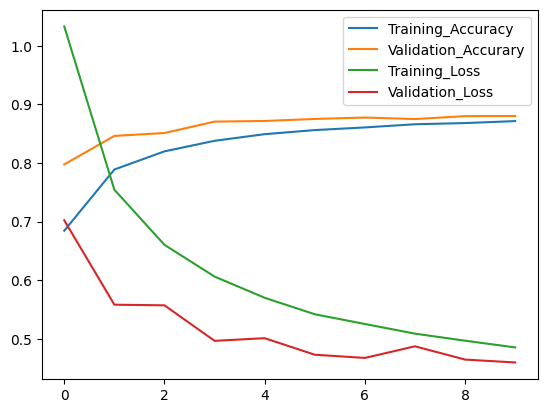

In [ ]:
acc = history_model_lstm1.history['accuracy']
val_acc = history_model_lstm1.history['val_accuracy']
loss = history_model_lstm1.history['loss']
val_loss = history_model_lstm1.history['val_loss']
plt.plot(acc, label='Training_Accuracy')
plt.plot(val_acc, label='Validation_Accurary')
plt.plot(loss, label='Training_Loss')
plt.plot(val_loss, label='Validation_Loss')
plt.legend()
plt.show()


### LSTM 2-layers

In [ ]:
from tensorflow.keras import layers
import tensorflow as tf

# Sequential model
model_lstm2 = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),  # Input layer
    text_vectorizer,                            # Text vectorization layer
    embedding,                                  # Embedding layer
    SpatialDropout1D(0.8),
    Bidirectional(LSTM(300, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(300, dropout=0.5, recurrent_dropout=0.5)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(9, activation='softmax'),
])

# Name the model
model_lstm2._name = 'Model_2_dense_sequential'

In [ ]:
# find the model summary
model_lstm2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (None, 20)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 20, 128)             │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (None, 20, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 20, 600)             │       1,029,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 600)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 600)                 │       2,162,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 600)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          38,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,791,049 (22.09 MB)

 Trainable params: 5,791,049 (22.09 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model.
model_lstm2.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
# model check points
checkpoint_callback = ModelCheckpoint(filepath="lastm-2-layer-best_model.keras", save_best_only=True, monitor="val_acc", mode="max", verbose=1)
early_stopping_callback = EarlyStopping(monitor="val_acc", mode="max", patience=10, verbose=1, restore_best_weights=True)

reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]


In [ ]:
history_model_lstm2 = model_lstm2.fit(train_sentences,
                              train_labels,
                              epochs=10,
                              batch_size=32,
                              validation_data=(valid_sentences, valid_labels),
                              callbacks=callbacks)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:567: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


3035/3035 ━━━━━━━━━━━━━━━━━━━━ 453s 145ms/step - accuracy: 0.6243 - loss: 1.2011 - val_accuracy: 0.7880 - val_loss: 0.7252 - learning_rate: 0.0010
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


3035/3035 ━━━━━━━━━━━━━━━━━━━━ 448s 148ms/step - accuracy: 0.7659 - loss: 0.8055 - val_accuracy: 0.8432 - val_loss: 0.5726 - learning_rate: 0.0010
Epoch 3/10
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 498s 146ms/step - accuracy: 0.8115 - loss: 0.6700 - val_accuracy: 0.8504 - val_loss: 0.5516 - learning_rate: 0.0010
Epoch 4/10
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 503s 147ms/step - accuracy: 0.8314 - loss: 0.6146 - val_accuracy: 0.8688 - val_loss: 0.5087 - learning_rate: 0.0010
Epoch 5/10
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 501s 147ms/step - accuracy: 0.8469 - loss: 0.5744 - val_accuracy: 0.8682 - val_loss: 0.4995 - learning_rate: 0.0010
Epoch 6/10
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 503s 147ms/step - accuracy: 0.8544 - loss: 0.5501 - val_accuracy: 0.8752 - val_loss: 0.4814 - learning_rate: 0.0010
Epoch 7/10
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 504s 148ms/step - accuracy: 0.8576 - loss: 0.5344 - val_accuracy: 0.8757 - val_loss: 0.4782 - learning_rate: 0.0010
Epoch 8/10
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 500s 147ms/step - acc

In [ ]:
# save the model
with open("/content/drive/MyDrive/swahili/models/model_lstm2.pkl", "wb") as file:
  pickle.dump(model_lstm2, file)

In [ ]:
def plot_model_training(model_history):
  acc = model_history.history['accuracy']
  val_acc = model_history.history['val_accuracy']
  loss = model_history.history['loss']
  val_loss = model_history.history['val_loss']
  plt.plot(acc, label='Training_Accuracy')
  plt.plot(val_acc, label='Validation_Accurary')
  plt.plot(loss, label='Training_Loss')
  plt.plot(val_loss, label='Validation_Loss')
  plt.legend()
  plt.show()

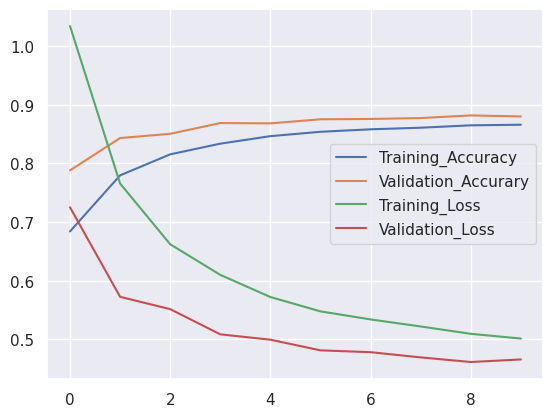

In [ ]:
plot_model_training(history_model_lstm2)

In [ ]:
# more LSTM hidden layers
# Sequential model
model_lstm5 = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),  # Input layer
    text_vectorizer,                            # Text vectorization layer
    embedding,                                  # Embedding layer
    SpatialDropout1D(0.8),
    Bidirectional(LSTM(300, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(300, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(300, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(300, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(300, dropout=0.5, recurrent_dropout=0.5)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(9, activation='softmax'),
])

# Name the model
model_lstm5._name = 'Model_5_dense_sequential'

In [ ]:
model_lstm5.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization_2                 │ (None, 20)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, 20, 128)             │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (None, 20, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 20, 600)             │       1,029,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 600)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 20, 600)             │       2,162,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 20, 600)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 20, 600)             │       2,162,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 20, 600)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 20, 600)             │       2,162,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 20, 600)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 600)                 │       2,162,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 600)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          38,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,278,249 (46.84 MB)

 Trainable params: 12,278,249 (46.84 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_lstm5.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
checkpoint_callback = ModelCheckpoint(filepath="lastm-5-layer-best_model.keras", save_best_only=True, monitor="val_acc", mode="max", verbose=1)
early_stopping_callback = EarlyStopping(monitor="val_acc", mode="max", patience=10, verbose=1, restore_best_weights=True)

reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]


In [ ]:
history_model_lstm5 = model_lstm5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              batch_size=32,
                              validation_data=(valid_sentences, valid_labels),
                              callbacks=callbacks)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:567: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


3035/3035 ━━━━━━━━━━━━━━━━━━━━ 1058s 342ms/step - accuracy: 0.5823 - loss: 1.3083 - val_accuracy: 0.7716 - val_loss: 0.8546 - learning_rate: 0.0010
Epoch 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


3035/3035 ━━━━━━━━━━━━━━━━━━━━ 1015s 335ms/step - accuracy: 0.7189 - loss: 0.9473 - val_accuracy: 0.7864 - val_loss: 0.7580 - learning_rate: 0.0010
Epoch 3/5
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 1009s 332ms/step - accuracy: 0.7558 - loss: 0.8554 - val_accuracy: 0.7867 - val_loss: 0.7338 - learning_rate: 0.0010
Epoch 4/5
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 1011s 333ms/step - accuracy: 0.7718 - loss: 0.8105 - val_accuracy: 0.7953 - val_loss: 0.6966 - learning_rate: 0.0010
Epoch 5/5
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 1026s 338ms/step - accuracy: 0.7852 - loss: 0.7698 - val_accuracy: 0.8141 - val_loss: 0.6668 - learning_rate: 0.0010


In [ ]:
# save the model
with open("/content/drive/MyDrive/swahili/models/model_lstm5.pkl", "wb") as file:
  pickle.dump(model_lstm5, file)

In [ ]:
# make predictions
model_lstm5_pred_probs = model_lstm5.predict(valid_sentences)
print(model_lstm5_pred_probs[:10])

338/338 ━━━━━━━━━━━━━━━━━━━━ 32s 90ms/step
[[4.57242643e-03 4.05363692e-03 3.69328144e-03 9.28433895e-01
  4.39355224e-02 2.37196265e-03 4.35792899e-04 8.28719512e-03
  4.21626540e-03]
 [6.81240868e-04 5.41145855e-04 5.08675002e-04 9.82879460e-01
  1.30573725e-02 4.33280220e-04 2.30046771e-05 1.14469626e-03
  7.31093751e-04]
 [4.11600893e-04 3.06801638e-04 3.00487911e-04 9.88710344e-01
  8.86383653e-03 2.70453194e-04 1.05494200e-05 6.74450130e-04
  4.51501517e-04]
 [3.33113596e-04 2.40798836e-04 2.37595668e-04 9.90697563e-01
  7.35452306e-03 2.22577029e-04 7.58939132e-06 5.34657098e-04
  3.71472066e-04]
 [4.51002717e-02 4.95742969e-02 3.72920968e-02 6.22165129e-02
  6.80905759e-01 3.00784614e-02 1.78296752e-02 2.02462021e-02
  5.67567460e-02]
 [6.54769305e-04 4.92931111e-04 4.87802870e-04 9.84503627e-01
  1.15954988e-02 4.22800600e-04 2.18224595e-05 1.13660702e-03
  6.84258062e-04]
 [6.82703801e-04 5.40144742e-04 5.10035083e-04 9.82971132e-01
  1.29563250e-02 4.34507005e-04 2.30920014e

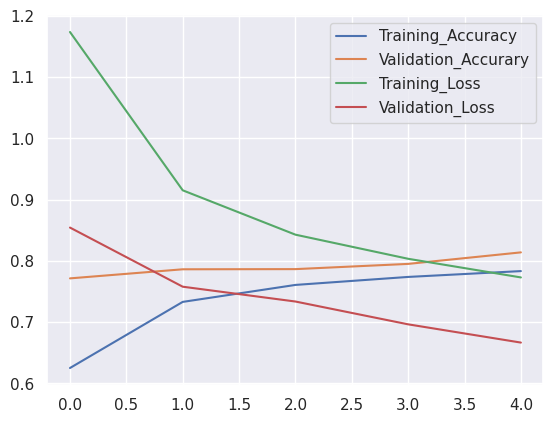

In [ ]:
plot_model_training(history_model_lstm5)

### GRU

the GRU have the same features as LSTM but have less parameters

In [ ]:

model_gru = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),  # Input layer
    text_vectorizer,                            # Text vectorization layer
    embedding,                                  # Embedding layer
    SpatialDropout1D(0.8),
    Bidirectional(GRU(300, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(GRU(300, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(GRU(300, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(GRU(300, dropout=0.5, recurrent_dropout=0.5)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(9, activation='softmax'),
])
model_gru._name = 'Model_gru_dense_sequential'

In [ ]:
model_gru.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization_2                 │ (None, 20)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, 20, 128)             │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_1                  │ (None, 20, 128)             │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 20, 600)             │         774,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 20, 600)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 20, 600)             │       1,623,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 20, 600)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 20, 600)             │       1,623,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 20, 600)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 600)                 │       1,623,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 600)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          38,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,243,849 (31.45 MB)

 Trainable params: 8,243,849 (31.45 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# compile the model.
model_gru.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
checkpoint_callback = ModelCheckpoint(filepath="lastm-gru-layer-best_model.keras", save_best_only=True, monitor="val_acc", mode="max", verbose=1)
early_stopping_callback = EarlyStopping(monitor="val_acc", mode="max", patience=10, verbose=1, restore_best_weights=True)

reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]


In [ ]:
# fit the model.
history_model_gru = model_gru.fit(train_sentences,
                              train_labels,
                              epochs=10,
                              batch_size=32,
                              validation_data=(valid_sentences, valid_labels),
                              callbacks=callbacks)

Epoch 1/10
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 1104s 359ms/step - accuracy: 0.3649 - loss: 12910.0459 - val_accuracy: 0.5696 - val_loss: 1.9001 - learning_rate: 0.0010
Epoch 2/10
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 1088s 354ms/step - accuracy: 0.3711 - loss: 297.4594 - val_accuracy: 0.5696 - val_loss: 1.5117 - learning_rate: 0.0010
Epoch 3/10
2163/3035 ━━━━━━━━━━━━━━━━━━━━ 5:04 349ms/step - accuracy: 0.3543 - loss: 151.1079

In [ ]:
with open("/content/drive/MyDrive/swahili/models/model_gru.pkl", "wb") as file:
  pickle.dump(model_gru, file)

In [ ]:
# make predictions
model_3_pred_probs = model_gru.predict(valid_sentences)
print(model_3_pred_probs[:10])

In [ ]:
plot_model_training(history_model_gru)

In [ ]:
# predictions
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 0., 0., 1., 0., 0., 1., 1., 0.], dtype=float32)>

### Model_4: Bidirectional RNN

**Normal RNN's go from left to right (the same way you will read a kiswahili sentence).
The bidirection RNN go from right to let as well as from  left to right**

In [ ]:
# build a bidirectional RNN
def text_augmenter(text):
  return tf.expand_dims(text, axis=0)

inputs = layers.Input(shape=(1, ), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(16, return_sequences=True))(x)
x = layers.Bidirectional(layers.GRU(64))(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_4_bidirectional = tf.keras.Model(inputs, outputs, name='model_4_bidirectional')

In [ ]:
model_4_bidirectional.summary()

In [ ]:
# Compile the model.
model_4_bidirectional.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
#  fit the model
model_4_biderectional_history = model_4_bidirectional.fit(train_sentences,
                              train_label,
                              epochs=5,
                              validation_data=(valid_sentences, valid_label))

In [ ]:
# evalutate the model
model_4_bidirectional.evaluate(valid_sentences, valid_label)

In [ ]:
# make predictions
model_4_pred_probs = model_4_bidirectional.predict(valid_sentences)
print(model_4_pred_probs[:10])

In [ ]:
# convert the prediction results to compatible features
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 0., 0., 1., 0., 0., 1., 1., 0.], dtype=float32)>

### CNN

In [ ]:
# Import the necessary layer
from tensorflow.keras.layers import GlobalAveragePooling1D

model_cnn = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),  # Input layer
    text_vectorizer,                            # Text vectorization layer
    embedding,                                  # Embedding layer
    SpatialDropout1D(0.8),
    Conv1D(filters=64, kernel_size=6, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=6, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=32, kernel_size=6, activation='relu'),
    MaxPooling1D(pool_size=2),
    GlobalAveragePooling1D(), # Now this line should work
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(9, activation='softmax'),
])

# Name the model
model_cnn._name = 'Model_5_dense_sequential'
model_cnn = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),  # Input layer
    text_vectorizer,                            # Text vectorization layer
    embedding,                                  # Embedding layer
    SpatialDropout1D(0.8),
    Conv1D(filters=64, kernel_size=6, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=6, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=32, kernel_size=6, activation='relu'),
    MaxPooling1D(pool_size=2),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(9, activation='softmax'),
])

# Name the model
model_cnn._name = 'Model_5_dense_sequential'

In [ ]:
model_cnn.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (None, 20)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 20, 128)             │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_5                  │ (None, 20, 128)             │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_12 (Conv1D)                   │ (None, 20, 64)              │          49,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_12 (MaxPooling1D)      │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_13 (Conv1D)                   │ (None, 10, 64)              │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_13 (MaxPooling1D)      │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_14 (Conv1D)                   │ (None, 0, 32)               │          12,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_14 (MaxPooling1D)      │ (None, 0, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,648,873 (10.10 MB)

 Trainable params: 2,648,873 (10.10 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_cnn.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
checkpoint_callback = ModelCheckpoint(filepath="cnn-layer-best_model.keras", save_best_only=True, monitor="val_acc", mode="max", verbose=1)
early_stopping_callback = EarlyStopping(monitor="val_acc", mode="max", patience=10, verbose=1, restore_best_weights=True)

reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]


In [ ]:
history_model_gru = model_cnn.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              batch_size=32,
                              validation_data=(valid_sentences, valid_labels),
                              callbacks=callbacks)

Epoch 1/5


UnknownError: Graph execution error:

Detected at node gradient_tape/sequential_3_1/conv1d_14_1/convolution/Conv2DBackpropFilter defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-98-c3d4a000eb0a>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 70, in train_step

CUDNN_STATUS_BAD_PARAM
in external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc(3731): 'tensor' CUDNN_BACKEND_TENSOR_DESCRIPTOR: Check and Set the CUDNN_ATTR_TENSOR_STRIDES Correctly
	 [[{{node gradient_tape/sequential_3_1/conv1d_14_1/convolution/Conv2DBackpropFilter}}]] [Op:__inference_one_step_on_iterator_8608]

In [ ]:
with open("/content/drive/MyDrive/swahili/models/model_gru.pkl", "wb") as file:
  pickle.dump(model_gru, file)

In [ ]:
# Make predictions


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
# The pabove plots are a clear intication of the model overfitting.
plot_model_training(model_5_cnn_history)

### Comaper the performance of all the medels